<div align=center>

<font size=5>
In the Name of God
<font/>
<p></p>
<br/>
<br/>
<font>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=cyan>
Artifical Intelligence - Dr. SamiEe
</font>
<br/>
<br/>

<hr/>
<font color=cyan>
Reinforcment Learning Practical Assignment
</font>
</div>

<ul>
  <li>Some cell's outputs have not been deleted. you can use these to make sure your implementation is correct.</li>
</ul>

In this notebook you will use the [openai gym](https://www.gymlibrary.dev/) library to train agent in reinforcment learning environment. Our environment is a discrete-state env (and it is deterministic).
make sure to upload your model performance video alongside this notebook. We suggest running this notebook on google colab so that you wont face any package errors.

we will first install the necessary packages.

In [71]:
!pip install gym==0.26
!pip install imageio imageio_ffmpeg
!pip install pygame
!pip install pyglet==1.5.1
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install 'gym[box2d]'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-2build1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Using cached swig-4.1.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
  error: subprocess-exited-with-error
  
  × python set

the functions below will be used to make a video of the model performance. It will start the environment and choose the best action based on the given Qtable.

In [72]:
from IPython.display import HTML
from base64 import b64encode
import imageio
import random
import numpy as np

## comment this part if your not using google colab
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()
######################

def record_video_taxi_env(env, Qtable, out_directory, fps=1, random_action=False):
  images = []
  done = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.random.randint(6)  if random_action else np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action)
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

def show_video(video_path, video_width = 500):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

## Part I: Taxi Environment (35 + 10 Points)

In [73]:
import numpy as np
import gym
import random
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In this exercise, we want to solve the Taxi-v3 environment. It is an environment, where we have a taxi, a passenger and a destination. taxi should go to the passenger's location, pick it up and then reach to destination and drop the passenger.
Please read more about this environment [here](https://www.gymlibrary.dev/environments/toy_text/taxi/)

**Question**  
Create an environment with the name `env` and print the number of states and actions.

In [74]:
env = gym.make('Taxi-v3', render_mode="rgb_array")
print(env.action_space)
print(env.observation_space)

Discrete(6)
Discrete(500)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  def step(self, action: ActType) -> Tuple[ObsType, float, bool, bool, dict]:
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  self.output_truncation_bool = output_truncation_bool


Let's run a random policy in this environement to get a better understanding of it.

In [75]:
record_video_taxi_env(env, None, 'taxi_random.mp4', fps=10, random_action=True)
show_video('taxi_random.mp4', video_width = 600)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:133: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'tuple'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


**Question**

Briefly describe the state space, action space, and reward function of this environment.

**Answer:**  
State Space: The state space in the Taxi-v3 environment is a 500-dimensional discrete space. Each state encodes the taxi's location in the grid (a 5x5 grid gives us 25 possible locations), the location of the passenger (5 possibilities: 4 passenger pickup locations and one additional 'in taxi' state), and the destination location (4 possibilities). Therefore, the total number of states is 25 taxi locations * 5 passenger locations * 4 destinations = 500 states.

Action Space: The action space in the Taxi-v3 environment is a 6-dimensional discrete space. The six actions are: move south, move north, move east, move west, pickup a passenger, and drop off a passenger.

Reward Function: The reward function in the Taxi-v3 environment is structured as follows:

The agent receives -1 for each action it takes. This encourages the agent to find the shortest possible path to pick up the passenger and drop them off at the destination.
There's a penalty of -10 for illegal pick-up and drop-off actions. An example of an illegal action is trying to pick up a passenger where there is none, or trying to drop off a passenger at a location that is not the destination.
The agent receives a large reward for a successful drop-off. The default reward for delivering the passenger is +20.
The goal of the agent is to learn a policy that maximizes the total reward it receives. This policy would involve navigating to the passenger, picking them up, navigating to the destination, and dropping the passenger off, all in the shortest amount of steps.


**Question**

Complete the code for `initialize_q_table` function. It should create a Q-table of size (state_space, action_space) and initializes it. You are free to use whichever initialization you want (a good starting point is to initialize it with all zeros)

In [76]:
def initialize_q_table(state_space, action_space):
    """
    Function to initialize the Q-table for Q-Learning.
    The Q-table is a two-dimensional numpy array where the first dimension corresponds to the state space and
    the second dimension corresponds to the action space.

    Args:
    state_space (int): The size of the state space.
    action_space (int): The size of the action space.

    Returns:
    np.array: The initialized Q-table.
    """
    Q_table = np.zeros((state_space, action_space))
    return Q_table

In [77]:
num_states = env.observation_space.n
num_actions = env.action_space.n
Qtable = initialize_q_table(num_states, num_actions)

**Question**

Complete the code for `epsilon_greedy_policy` function. It should select the best action according to the current Q-function with probability $1-\varepsilon$ and select a random action with probability $\varepsilon$.

In [78]:
import random
import numpy as np

def epsilon_greedy_policy(Qtable, state, epsilon):
    """
    Function to perform action selection using the epsilon-greedy policy.
    With probability epsilon, a random action is selected, and with probability (1-epsilon),
    the action with the highest Q-value for the current state is selected.

    Args:
    Qtable (np.array): The Q-table.
    state (int): The current state.
    epsilon (float): The probability of selecting a random action.

    Returns:
    int: The selected action.
    """
    if random.uniform(0, 1) < epsilon:
        action = random.randint(0, len(Qtable[0]) - 1)
    else:
        action = np.argmax(Qtable[state])
    return action

**Question**
You need to choose appropriate hyperparameters for the agent to learn.

In particular, you must find a suitable learning rate and exploration parameters. To facilitate exploration, a common practice is to start with a high exploration rate ($\varepsilon$) and gradually decrease it as the agent gets better. To implement this, you need to specify the starting exploration rate (`max_epsilon`), the final exploration rate (`min_epsilon`) and a decay rate which reduces the exploration rate after each update (see the `train` function below).

In [79]:
# Training parameters
n_training_episodes = 10000
n_eval_episodes = 100
learning_rate = 0.1           # Learning rate

# Environment parameters
max_steps = 1000               # Max steps per episode
gamma = 0.9                    # Discounting rate

# Exploration parameters
max_epsilon = 0.99           # Exploration probability at start
min_epsilon = 0.1              # Minimum exploration probability
decay_rate = 0.99            # Exponential decay rate for exploration prob

**Question**

Complete the `train` function which updates `Qtable` using the Q-learning update rule.

In [80]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable, learning_rate, gamma):
    epsilon = max_epsilon
    for episode in range(n_training_episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0
        for step in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            new_state, reward, done, info = env.step(action)

            Qtable[state, action] += learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state, action])
            total_reward += reward
            state = new_state

            if done:
                break

        epsilon = decay_rate*epsilon if decay_rate*epsilon > min_epsilon else min_epsilon
    return Qtable

We are now ready to train our agent.

In [81]:
import gym
import numpy as np

# Create environment
env = gym.make('Taxi-v3')

# Initialize Q-table
num_states = env.observation_space.n
num_actions = env.action_space.n
Qtable = initialize_q_table(num_states, num_actions)

Qtable_trained = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable, learning_rate, gamma)

Now, we will evaluate our agent. You don't need to write any code, just run the following cells as they are.

In [82]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    state, info = env.reset()
    step = 0
    terminated = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action = np.argmax(Q[state][:])
      new_state, reward, terminated, info = env.step(action)

      total_rewards_ep += reward

      if terminated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [91]:
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_trained)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}") # should be around 0.65

100%|██████████| 100/100 [00:00<00:00, 1459.24it/s]

Mean_reward=8.02 +/- 2.51


Now let's see how well our model is doing.

In [92]:
record_video_taxi_env(env, None, 'taxi_random.mp4', fps=10, random_action=True)
show_video('taxi_random.mp4', video_width = 600)

AssertionError: ignored

Next, we will take a look at the Q-function that was learned.

In [66]:
print(Qtable_trained)

[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.83087442 -0.90691874 -1.57675049 -0.20801073  1.62261467 -8.3045697 ]
 [ 3.15099597  4.28560311  2.25776295  2.41603736  7.7147     -4.68063136]
 ...
 [-1.18684459  4.56187202 -1.21673173 -1.18334011 -4.19087093 -4.1677579 ]
 [-2.49838284 -2.51290717 -2.30156297  0.82051053 -4.46918958 -3.59831155]
 [ 1.23367127 -0.29713312  1.32788535 16.94785039 -1.53281795  0.        ]]


**Question**

Assume that `Qtable_trained` is the correct Q-function for the final epsilon-greedy policy that was used in training. What is the value function that corresponds to this policy? Write down the relation between $V_\pi$ and $Q_\pi$ and use it to complete the following code block.

**Answer:**


In [67]:
Vtable_trained = [max(Qtable_trained[i]) for i in range(len(Qtable_trained))]

Take a look at the value function

In [68]:
print(Vtable_trained)

[0.0, 1.6226146699999648, 7.714699999999958, 2.914016299999962, -5.097621000332964, 0.0, -5.178240623810283, -3.4138295894393145, 1.1892435613168928, -2.5194723535802797, 0.0, -1.531750157235304, -3.882970894581556, -2.6484971495152623, -4.120018489686837, 0.0, 19.999999999999986, 2.914016299999962, 9.682999999999957, 4.34890699999996, 0.0, 0.4529381286536611, 5.925066157112468, 1.6165286643084684, -4.493588347665273, 0.0, -4.447203282253254, -2.8463134868701867, 0.2667494822590865, -3.396639646952161, 0.0, -2.6905828442880213, -3.137610483741734, -1.5468383911200585, -3.294006745702782, 0.0, 16.839879853268723, 3.0608322295061083, 5.335093453640758, 5.740313913340418, 0.0, -4.074078446888599, -0.9401087583002556, -3.3890221905124127, -0.8169909566097526, 0.0, -0.6271420285922878, 2.8667228445928097, -0.9247213031841489, -3.960879244167772, 0.0, -3.17984216678568, -2.5673228650399995, -1.0278545038105784, -2.578296571955364, 0.0, 4.815813273845856, 3.65504781662187, -1.2464757553538712

**Question**  
Write a function to generate a visualization for the value function using a heatmap. In a few words, explain what you see.

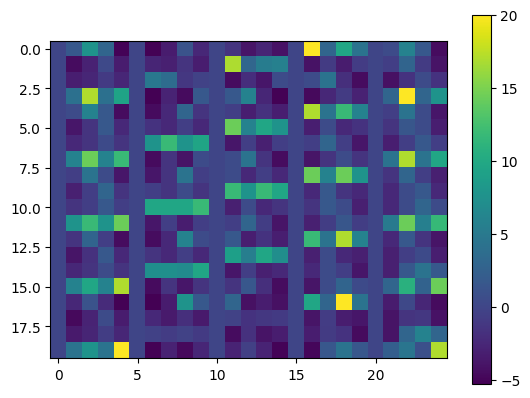

In [69]:
import matplotlib.pyplot as plt


def visualize(Vtable):
  """
  Visualize the value function
  :param Vtable: The value function
  """
  plt.imshow(Vtable, cmap='viridis', interpolation='nearest')
  plt.colorbar()
  plt.show()
  ...
#reshape 500 states to (25,20) matrix
visualize(np.reshape(Vtable_trained,(20,25)))

**Question**  
Can we use a pure greedy policy for Q-learning? Explain.

Yes, it's technically possible to use a pure greedy policy for Q-learning. However, it's generally not a good idea, especially during the initial stages of training. Here's why:

Q-learning is an off-policy method, meaning that it learns from actions that are outside the current policy being used, and a pure greedy policy is just one type of policy that could be used. The problem with a pure greedy policy is that it doesn't explore the environment well because it always selects the action with the highest expected reward according to the current Q-values.

In the beginning of learning, our Q-values are not accurate, so a pure greedy policy can result in suboptimal action selection, leading to poor exploration of the state-action space and potential getting stuck in local optima. This is often referred to as the exploration-exploitation dilemma: do we exploit what we currently know to get the best rewards (greedy policy), or do we explore the environment to make better informed decisions in the future?

To mitigate this, one common approach is to use an ε-greedy policy, which selects the best action most of the time (greedy), but with a probability ε, it will select a random action (exploration). Over time, ε is often decayed to shift the balance from exploration towards exploitation as we get more confident in our Q-values.

However, once the agent is trained and we are confident in the accuracy of the Q-table, we can indeed use a pure greedy policy for the policy execution because at this point, the goal is to exploit the knowledge that the agent has learned to get the maximum possible reward, and no further exploration is needed.